<a href="https://colab.research.google.com/github/neelam-pharswan/Trader-Behavior-Insights/blob/main/Trader_Behavior_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

# Load data
trader_df = pd.read_csv('/content/drive/My Drive/Dataset/historical_data.csv')
sentiment_df = pd.read_csv('/content/drive/My Drive/Dataset/fear_greed_index.csv')

# Convert 'Timestamp IST' to datetime
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['Timestamp IST'].dt.date

# Convert sentiment 'date' to datetime.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
sentiment_df.rename(columns={'classification': 'Sentiment'}, inplace=True)

# Merge on 'date'
merged_df = pd.merge(trader_df, sentiment_df[['date', 'Sentiment']], on='date', how='inner')

merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,Sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


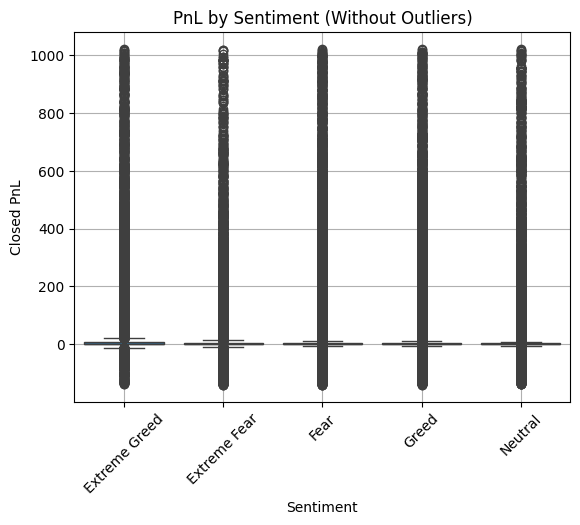

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove extreme outliers (e.g. top/bottom 1%)
filtered_df = merged_df[(merged_df['Closed PnL'] > merged_df['Closed PnL'].quantile(0.01)) &
                        (merged_df['Closed PnL'] < merged_df['Closed PnL'].quantile(0.99))]

sns.boxplot(data=filtered_df, x='Sentiment', y='Closed PnL')
plt.title("PnL by Sentiment (Without Outliers)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [7]:
print(merged_df.groupby('Sentiment')['Closed PnL'].mean())

Sentiment
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


In [8]:
summary = merged_df.groupby(['date', 'Sentiment']).agg({
    'Closed PnL': ['mean', 'sum'],
    'Size USD': 'sum',
    'Account': 'nunique'
}).reset_index()
summary.columns = ['date', 'Sentiment', 'Avg_PnL', 'Total_PnL', 'Total_Trade_Volume', 'Unique_Traders']
summary.head()

,date,Sentiment,Avg_PnL,Total_PnL,Total_Trade_Volume,Unique_Traders
0,2023-05-01,Greed,0.000000,0.000000,477.00,1
1,2023-12-05,Extreme Greed,0.000000,0.000000,50005.83,1
2,2023-12-14,Greed,-18.675885,-205.434737,113203.35,1
3,2023-12-15,Greed,-12.316017,-24.632034,10609.95,1
4,2023-12-16,Greed,0.000000,0.000000,15348.77,1


In [10]:
# Compare Buy vs Sell under each sentiment
buy_sell_pnl = merged_df.groupby(['Sentiment', 'Side'])['Closed PnL'].mean().unstack()
print(buy_sell_pnl)

Side                 BUY        SELL
Sentiment                           
Extreme Fear   34.114627   34.980106
Extreme Greed  10.498927  114.584643
Fear           63.927104   45.049641
Greed          25.002302   59.691091
Neutral        29.227429   39.456408
